# Distributed Computation
*Blaine Rogers &lt;<br1314@ic.ac.uk>&gt; 26-09-2016*

This notebook explores using the TensorFlow distributed runtime with the classes in `gptf.distributed` to distribute computation across a cluster. We'll start by generating a full gp to test against, a template expert and some data.

In [1]:
import datetime
import gptf
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

full_gp = gptf.gpr.GPR(gptf.kernels.RBF(variance=10.), noise_variance=.5)

def new_expert():
    return gptf.gpr.GPR(
        gptf.kernels.RBF(variance=10.),
        noise_variance=.5
    )

X = np.random.uniform(0., 10., (20, 1))
Y = full_gp.compute_prior_samples(X, 1, 1)[0]
Y += np.random.normal(0., np.sqrt(full_gp.likelihood.variance.value), Y.shape)

test_points = np.linspace(-5, 10, 100).reshape(-1, 1)

As can be seen in section 4 of [Deisenroth & Ng (2015)][deisenroth15], an rBCM can be constructed as a computational graph, with GP experts at the leaves, a layer of gPoE models, then arbitrarily many layers of PoE models, followed by a prior correction at the root.

[deisenroth15]: http://jmlr.org/proceedings/papers/v37/deisenroth15.pdf

In [2]:
experts = [new_expert()] * 10

rbcm = gptf.distributed.rBCMReduction(
    experts, gptf.distributed.cao_fleet_weights
)

In [3]:
# create a 2, 5 hierachy
#            prior correction
#                  |
#                 PoE
#           /              \
#        gPoE             gPoE
#   /  /  |  |  \    /  |  |  \  \
#  E  E   E  E   E  E   E  E   E  E

# create gPoE layer
weights = gptf.distributed.cao_fleet_weights
layer = [gptf.distributed.gPoEReduction(experts[i:i+5], weights)
         for i in range(0, len(experts), 5)]

# create PoE layer
root = gptf.distributed.PoEReduction(layer)

# add prior correction
def total_weight(_, X, Y, points):
    w = weights(experts, X, Y, points)
    return [tf.reduce_sum(tf.pack(w, 0), 0)]
tree_rbcm = gptf.distributed.PriorDivisorReduction(root, total_weight)


Below, we check the posterior mean and variance of our two rBCMs to ensure that they are the same.

Means are approx. equal: True
Variances are approx. equal: True


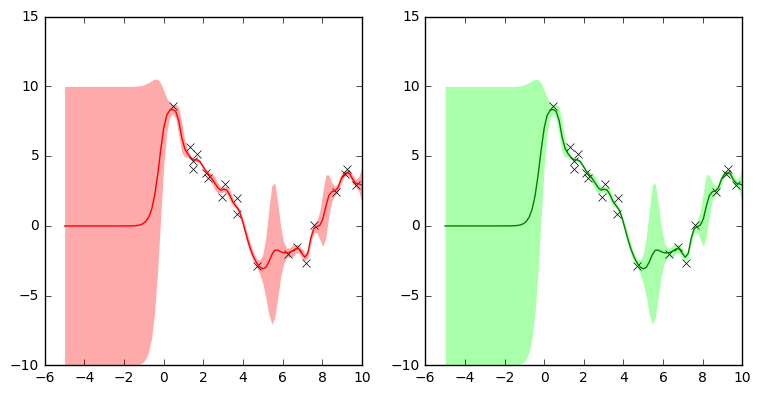

In [4]:
mean_a, var_a = rbcm.compute_posterior_mean_var(X, Y, test_points)
mean_b, var_b = tree_rbcm.compute_posterior_mean_var(X, Y, test_points)

print("Means are approx. equal: {}".format(np.allclose(mean_a, mean_b)))
print("Variances are approx. equal: {}".format(np.allclose(var_a, var_b)))

plt.figure(figsize=(9, 4.5))
axes = plt.subplot(121)
plt.plot(X, Y, 'kx',
         test_points, mean_a, 'r-')
plt.fill_between(test_points[:,0],
                 (mean_a + var_a)[:,0],
                 (mean_a - var_a)[:,0],
                 color='#ffaaaa', linewidth=0.)
plt.subplot(122, sharey=axes)
plt.plot(X, Y, 'kx',
         test_points, mean_b, 'g-')
plt.fill_between(test_points[:,0],
                 (mean_a + var_a)[:,0],
                 (mean_a - var_a)[:,0],
                 color='#aaffaa', linewidth=0.)
plt.show()

`gptf.distributed.TreerBCM` does this construction for you, given a list of branching factors. For instance, 

```python
gptf.distributed.TreerBCM(expert, weights, [3, 4, 5])
```

would create an rBCM with a prior divisor node at the root, whose child is a PoE node with three PoE children, each of which has four gPoE children with weightfunction `weights`, each of which has five children that are copies of `expert`.

In [5]:
tree_rbcm0 = gptf.distributed.TreerBCM(
    experts, gptf.distributed.cao_fleet_weights, [2, 5]
)

mean_c, var_c = tree_rbcm0.compute_posterior_mean_var(X, Y, test_points)

print("Means are approx. equal: {}".format(np.allclose(mean_a, mean_c)))
print("Variances are approx. equal: {}".format(np.allclose(var_a, var_c)))

Means are approx. equal: True
Variances are approx. equal: True
